In [6]:
import pandas as pd
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()
df = pd.DataFrame(data=data.data, columns=data.feature_names)
df['target'] = pd.Series(data.target)
pd.set_option('display.max_columns', 10)
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,...,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,...,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,...,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,...,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,...,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,...,0.4000,0.1625,0.2364,0.07678,0


In [26]:
df = df[['mean area', 'mean concavity']]
df.head()

,mean area,mean concavity
0,1001.0,0.3001
1,1326.0,0.0869
2,1203.0,0.1974
3,386.1,0.2414
4,1297.0,0.1980


In [27]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

x = df['mean area'][:100]
y = df['mean concavity'][:100]
xy = np.column_stack((x, y))

In [28]:
print(f'x min: {x.min()}')
print(f'x max: {x.max()}')
print(f'y min: {y.min()}')
print(f'y max: {y.max()}')

x min: 201.9
x max: 1878.0
y min: 0.000692
y max: 0.3754


In [29]:
print(xy[:10])

[[1.001e+03 3.001e-01]
 [1.326e+03 8.690e-02]
 [1.203e+03 1.974e-01]
 [3.861e+02 2.414e-01]
 [1.297e+03 1.980e-01]
 [4.771e+02 1.578e-01]
 [1.040e+03 1.127e-01]
 [5.779e+02 9.366e-02]
 [5.198e+02 1.859e-01]
 [4.759e+02 2.273e-01]]


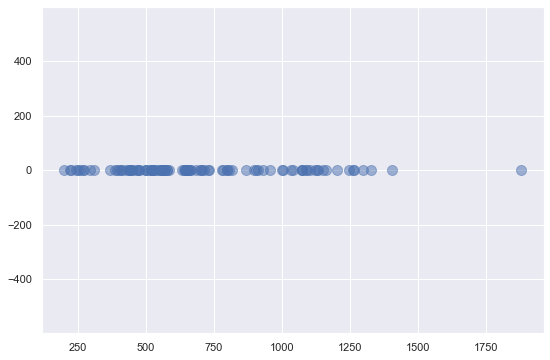

In [30]:
plt.figure(figsize=(9, 6))
plt.axis('equal')
plt.scatter(x, y, s=100, alpha=0.5)

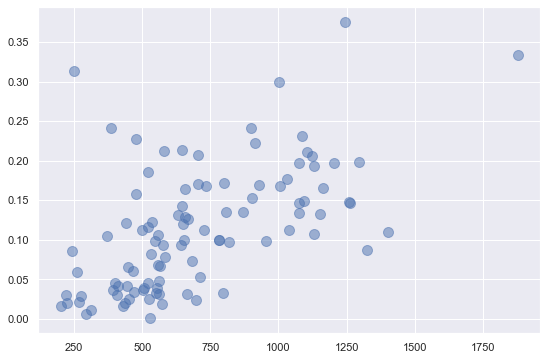

In [31]:
plt.figure(figsize=(9, 6))
plt.scatter(x, y, s=100, alpha=0.5)

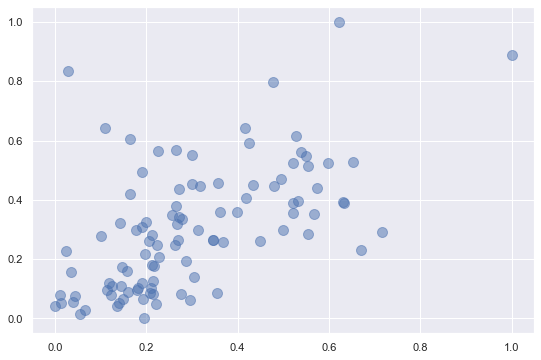

In [32]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
xy_norm = scaler.fit_transform(xy)

plt.figure(figsize=(9, 6))
plt.scatter(xy_norm[:, 0], xy_norm[:, 1], s=100, alpha=0.5)

In [33]:
print(xy_norm[:10])

[[0.47676153 0.79904352]
 [0.67066404 0.23006715]
 [0.5972794  0.52496344]
 [0.10989798 0.64238821]
 [0.65336197 0.52656469]
 [0.16419068 0.41928115]
 [0.50002983 0.29892076]
 [0.22433029 0.24810786]
 [0.18966649 0.49427287]
 [0.16347473 0.60475891]]


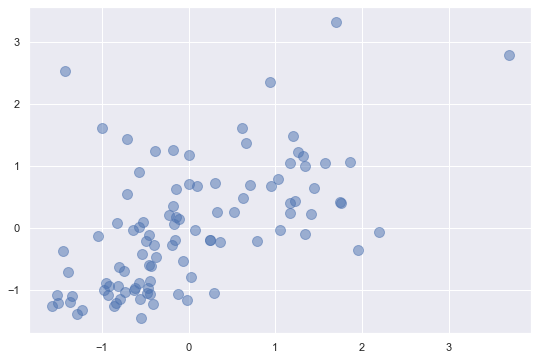

In [34]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
xy_norm = scaler.fit_transform(xy)

plt.figure(figsize=(9, 6))
plt.scatter(xy_norm[:, 0], xy_norm[:, 1], s=100, alpha=0.5)

In [35]:
print(xy_norm[:10])

[[ 0.93457642  2.36212718]
 [ 1.95483237 -0.35495682]
 [ 1.56870474  1.05328794]
 [-0.99574783  1.61403698]
 [ 1.86379415  1.06093451]
 [-0.71007617  0.5486138 ]
 [ 1.05700714 -0.02615397]
 [-0.39363986 -0.26880538]
 [-0.57603023  0.90672853]
 [-0.71384326  1.4343424 ]]
